# Goal
- Staying up to date with the latest reseach literature is really painful. If you had to do this for work or studies you know how time consuming it can be. 
- In this demo we will show how you can leverage LLMs to monitor publications feeds (e.g. arXiv) to evaluate whether there are any relevant papers from your area of study, and if so, get an email with a summary of the paper, main take away, and a link to the paper. 
- For this demo we will use arXiv RSS feeds, which updates daily with the papers published in the last 24hs. 
- The approch we will take will be to:
    1. Parse the feed to extract all paper's titles, abstracts, and URL
    2. For every paper ask an LLM model whether it's relevant to our area of research (defined by us), and what's the summary and main takeaway. 
    3. For the relevant papers, we will sends us an email with that information.
- We will use [Instructor](https://python.useinstructor.com/) to ensure we get the desired structured data back fromt the model. 

In [ ]:
# for loading environment variables
from dotenv import load_dotenv
import os

# for reading and parsing the arXiv feed
import feedparser

# for getting structured outputs from the LLM
import instructor
from anthropic import Anthropic
from pydantic import BaseModel

# For sending email
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

# Global variables
- We first need to load the environment variables (for the LLM API KEY and the email password), and set up the global variables for the RSS feed and the model we want to use. You'll need to do this by creating a .env file with the two variables you need.
- For this demo we will use Claude Sonnet 3.5 from anthropic, altough the same can be done with any state of the art model. 
- For this demo we are going to work with the arXiv RSS feed fot Computer Science - Artificial intelligence (https://rss.arxiv.org/rss/cs.ai). There are many categories and subject classes you can choose to monitor. In this case Computer Science is the Category, and AI is the subject class. You can find more information about the RSS feed [here](https://info.arxiv.org/help/rss.html), and about the classes [here](https://info.arxiv.org/help/rss.html). 

In [2]:
load_dotenv()

# RSS Feed URL
RSS_FEED_URL = "https://rss.arxiv.org/rss/cs.ai"

# Select model to use
MODEL = "claude-3-5-sonnet-latest"

# Reading and parsing the feed.
- We will parse the feed that contains all the papers published in the last 24. 
- For each paper we will extract Title, Abstract, and URL.
- We will first pull the latest feed and print it so you can explore it, but for the rest of the document we will use a demo feed from the day I'm actually writing this. 
- For the day we are running this, there have been 278 papers published out of the ones of course only a few will be relevant!

In [27]:
feed = feedparser.parse(RSS_FEED_URL)
print(str(feed)[:500])


{'bozo': False, 'entries': [{'title': 'Being Considerate as a Pathway Towards Pluralistic Alignment for Agentic AI', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'https://rss.arxiv.org/rss/cs.ai', 'value': 'Being Considerate as a Pathway Towards Pluralistic Alignment for Agentic AI'}, 'links': [{'rel': 'alternate', 'type': 'text/html', 'href': 'https://arxiv.org/abs/2411.10613'}], 'link': 'https://arxiv.org/abs/2411.10613', 'summary': "arXiv:2411.10613v1 Announce Type: new \n


In [18]:
# Load and parse the RSS feed from the sample file
with open("./data/sample_feed.xml", "rb") as file:
    feed_content = file.read()

# Use feedparser to parse the static feed
# To run if on live data change feed_content for RSS_FEED_URL
feed = feedparser.parse(feed_content)
entries = []
for entry in feed.entries:
    entries.append(
        {"title": entry.title, "abstract": entry.summary, "link": entry.link}
    )

# Checking one example file
print(f"Title: {entries[0]["title"]}")
print(f"Abstract: {entries[0]["abstract"]}")
print(f"Link: {entries[0]["link"]}")

# How many papers do we need to filter through?
print("-------")
print(f"In total there are {len(entries)} new papers published in this category in the last 24hs.")
print("-------")


Title: Being Considerate as a Pathway Towards Pluralistic Alignment for Agentic AI
Abstract: arXiv:2411.10613v1 Announce Type: new 
Abstract: Pluralistic alignment is concerned with ensuring that an AI system's objectives and behaviors are in harmony with the diversity of human values and perspectives. In this paper we study the notion of pluralistic alignment in the context of agentic AI, and in particular in the context of an agent that is trying to learn a policy in a manner that is mindful of the values and perspective of others in the environment. To this end, we show how being considerate of the future wellbeing and agency of other (human) agents can promote a form of pluralistic alignment.
Link: https://arxiv.org/abs/2411.10613
-------
In total there are 278 new papers published in this category in the last 24hs.
-------


# Structuring the ouput
- In order to ensure structure data from the model, we are going to use Instructor. This is a great library to use if you want to easily and reliable ensure structure data out of the most used LLM providers. You don't need to use this as many of them have already provided their own structured output features, but, it does help maintain similar interfaces between models, you get validations and retries already included, etc. 
- The way Instructor work is that you define a pydantic class with the fields and types you want the model to output, and then pass that to the model via a wrapper created around the original provider client. 
- For our use case we want to be able to send the model the paper title and abstract, and get back 3 pieces of informations:
    1. Is it TRUE or FALSE that the paper is related to our area of interest / what we are looking for (we will use this to decide whether to include this paper in the daily email or not) 
    2. What's the model reasoning for that decision (this will help us also quickly understand why we should care)
    3. What's the main takeaway from the paper (will help us decide if we want to dive deeper after reading the notification email)

In [11]:
class Categorization(BaseModel):
    is_related: bool
    reasoning: str
    takeaway: str

# Building the prompt
- We need to tell the model what are the topics or areas we are interested and guide it towards the data we need to get out in the response. We do that via the prompt. The quality of the filtering will depende a lot on this so it's important to get it right and/or iterate over time. 
- For this demo we want to monitor for papers realated to Multi-Agent Coordination. So we will explain in the prompt that we want to focus on that field, as well as describe for the model what that field is about.
- Since we are going to use this in more than one place we will crate a function that takes in the title and the abstract of the paper and returns the prompt. 


In [19]:
def prompt_builder(title, abstract):
    return f"""
                - I'm a reseracher in the field of AI interested in Multi Agent Coordination. 
                - Multi Agent Coordination is the field of AI research that focusses in nderstanding 
                how agents can effectively collaborate, communicate, and divide tasks to achieve a 
                common objective.
                - I'll share with you a paper title and paper abstract and I want you to tell me 
                whether it's True that the paper is related to my field of interest or whether that 
                is False. By field of interest I mean that it should be both related to AI and to 
                Multi Agents Coordination. If it's to only one of them, then it should be False. 
                
                Idditionally, you should also output a brief explanation of your reasoning on why is this paper 
                relevant for me, and asummary of the main takeaway. Be very brief on their writing. 
                
                Paper title = {title}
                Paper abstract = {abstract}
            
            """

# Example
- Before running the process on all the files, let's try with one example.
- This is a paper about pluralistic alignment for agentinc AI, so the model should return Falses, since it's not about multi agent coordination.
- You can see the paper here: https://arxiv.org/pdf/2411.10613

In [22]:
# initialize the client
client = instructor.from_anthropic(Anthropic(api_key=os.getenv("ANTROPHIC_KEY")))

# get info for first file
entry = entries[0]
title = entry["title"]
abstract = entry["abstract"]
print(f"Processing paper with title: {title}...")

prompt = prompt_builder(title, abstract)

resp = client.messages.create(
    model=MODEL,
    max_tokens=1024,
    messages=[{"role": "user", "content": prompt}],
    response_model=Categorization,
)

print(f"Is Related: {resp.is_related}")
print(f"Reasoning: {resp.reasoning}")
print(f"Takeaway: {resp.takeaway}")

Processing paper with title: Being Considerate as a Pathway Towards Pluralistic Alignment for Agentic AI...
Is Related: False
Reasoning: While this paper is clearly related to AI (specifically agentic AI and alignment), it doesn't focus on multi-agent coordination aspects. The paper primarily discusses how a single AI agent can be mindful and considerate of human values/perspectives, rather than how multiple agents coordinate to achieve common goals.
Takeaway: The paper proposes that AI systems can achieve better alignment with human values by being considerate of humans' future wellbeing and agency, promoting pluralistic alignment that respects diverse human perspectives.


# Filtering papers
- Now that we know how to evaluate individual papers, we can iterate over all the papers in the feed and find the ones we care about (which should be the ones that return resp.is_related = True).
- We will save the ones that are related into an array so that we can then send an email with the relevant papers and their data.
- In the end ony  7 papers out of 278 were relevant for us. 

In [23]:
# Create a list to store relevant papers
relevant_papers = []
for entry in entries:

    title = entry["title"]
    abstract = entry["abstract"]

    print(f"Processing paper with title: {title} ({entries.index(entry) + 1}/{len(entries)})")

    prompt = prompt_builder(title, abstract)

    resp = client.messages.create(
        model=MODEL,
        max_tokens=1024,
        messages=[{"role": "user", "content": prompt}],
        response_model=Categorization,
    )

    if resp.is_related:
        relevant_papers.append((title, entry["link"], resp.reasoning, resp.takeaway))
        print(f"----> Added paper to list of relevant papers, currenty consisting of {len(relevant_papers)} papers")
        

Processing paper with title: Being Considerate as a Pathway Towards Pluralistic Alignment for Agentic AI (1/278)
Processing paper with title: Pluralistic Alignment Over Time (2/278)
Processing paper with title: Reinforcing Competitive Multi-Agents for Playing So Long Sucker (3/278)
Adding paper to list of relevant papers, currenty consisting of 0 papers
Processing paper with title: Syllabus: Portable Curricula for Reinforcement Learning Agents (4/278)
Processing paper with title: Robust Markov Decision Processes: A Place Where AI and Formal Methods Meet (5/278)
Processing paper with title: Alien Recombination: Exploring Concept Blends Beyond Human Cognitive Availability in Visual Art (6/278)
Processing paper with title: Search, Verify and Feedback: Towards Next Generation Post-training Paradigm of Foundation Models via Verifier Engineering (7/278)
Processing paper with title: A Pre-Trained Graph-Based Model for Adaptive Sequencing of Educational Documents (8/278)
Processing paper with 

# Email
- Now that we know what papers are relevant for us, and we know why and what's the main takeaways (we got that in the reply from the model), we can send ourselves an email with that information! 
- I'll be using gmail. If you are also using gmail you need to create an App Password following [these](https://knowledge.workspace.google.com/kb/how-to-create-app-passwords-000009237) instructions.
- And that's it! we are done! 

In [26]:
# Email credentials
sender_email = "bdagnino@gmail.com"
receiver_email = "bruno@limai.io"
password = os.getenv("APP_PASSWORD")

# Email content
subject = "New arXiv Papers for you!"
body = "<html><body>These papers are related to your area of interest:<br><br>"
for title, link, reasoning, takeaway in relevant_papers:
    body += f"<b>Title:</b> {title}<br>"
    body += f"<b>Link:</b> {link}<br>"
    body += f"<b>Reasoning:</b> {reasoning}<br>"
    body += f"<b>Main Takeaway:</b> {takeaway}<br><br>"
body += "</body></html>"

# Setting up the email
msg = MIMEMultipart()
msg["From"] = sender_email
msg["To"] = receiver_email
msg["Subject"] = subject
msg.attach(MIMEText(body, "html"))

try:
    # Connect to the Gmail SMTP server
    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()  # Encrypt the connection
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, msg.as_string())
        print("Email sent successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

Email sent successfully!


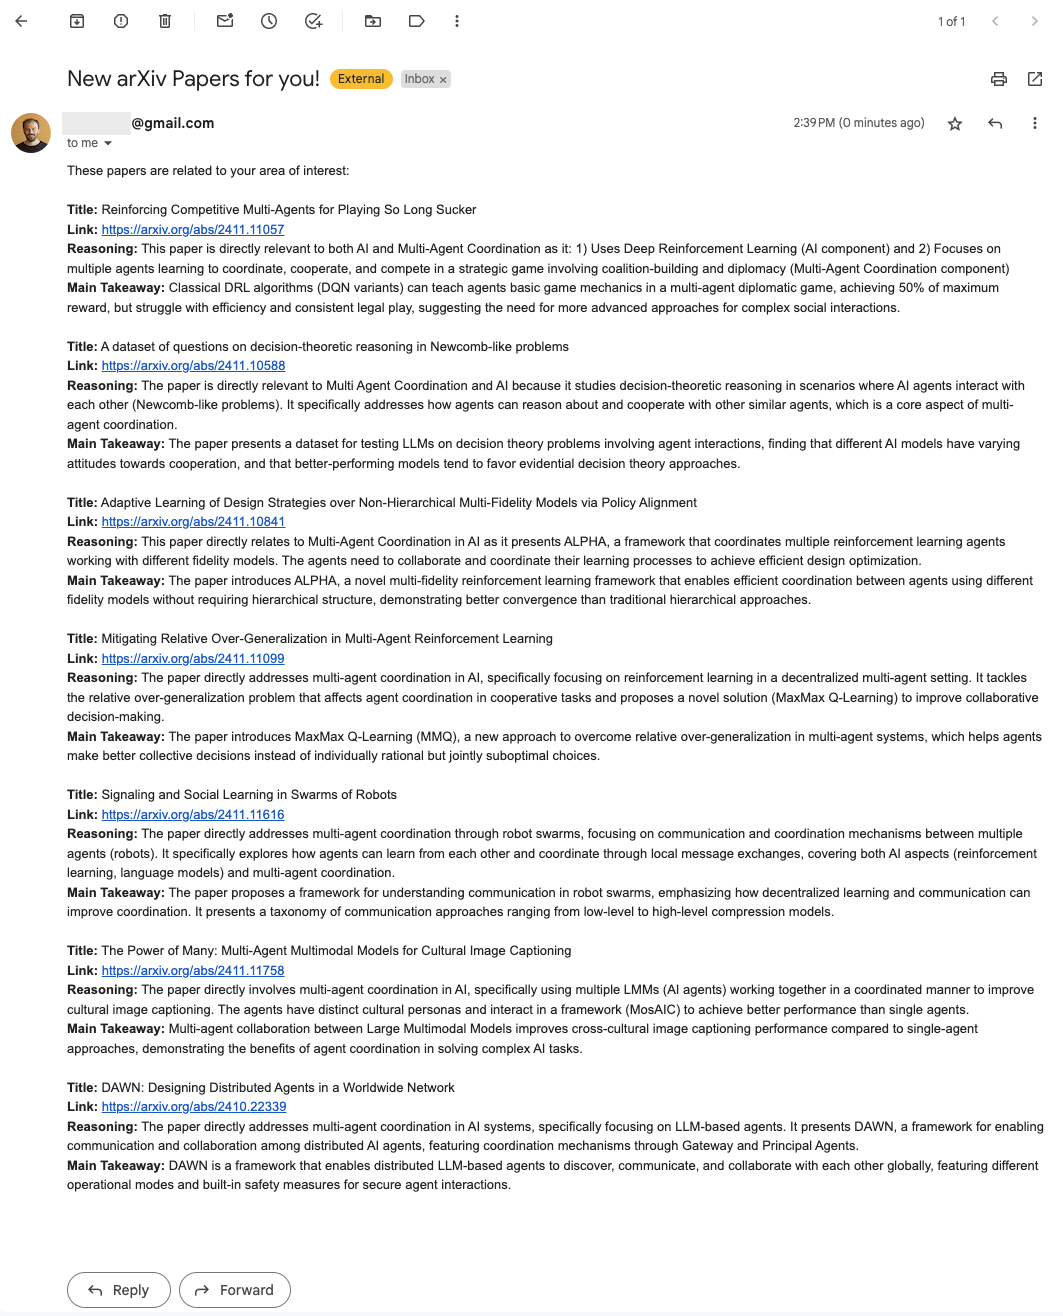

# Costs
- A quick word on costs. Using Anthropic's Claude Sonnetc 3.5, evaluating all the papers for this single day had a cost of 80cts. Although not much on itself, if you want to run this daily, that starts to add up. 
- Some alternatives to this are to use either a smaller model like Anthropics Haiku which would cost a third (~27cts), or to use cheaper models from other providers. 
- For example you could use Google's Gemini Flash model which would've costed ~4cts per day, which you can actually can get for free if you process less than 15 documents per minute.

# Next Steps
- If you want to build on this, you can take this code, add your keys, and create a cron job that runs this script every day. 
- On our end, we are working on a new feature in Limai that will allow you to do this via without needing to code so stay tunned for that if you are interested!